This is the jupyter file to be used for running each part of the code. Read through each section and click the run button (after hovering over the cell) to run the code. The code is split into 3 parts: Image Processing, Matching, and Assembling. Each part is run separately and the results are displayed in the output.

The original author of this application is Maxim Terleev. The source files can be seen in the following GitHub repository:
https://github.com/MaximTerleev/Jigsaw-Puzzle-AI/blob/main/jigsaw-puzzle-solver.py

The solver contains many functions and can be split into 3 main sections:
1. Image Processing
2. Matching
3. Assembling

## Imports

In [16]:
# imports
from scipy.ndimage import median_filter
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
from fastdtw import fastdtw
import numpy as np
import cv2

# Image processing

For processing the image, we take a scanned image of some jigsaw puzzle pieces as input. The image has to be a good quality scan with a distinctive background and puzzle pieces. The image is then processed to extract the puzzle pieces from the background. The puzzle pieces are then stored in a list.

Here are a couple functions for showing output. Running them doesn't do anything at the moment. But they will be used throughout the code for output, so it's important to run this cell first.

In [17]:
# @title Functions

def showpic(image, width=10):
  plt.figure(figsize=(width, width/1000*727))
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()

def showlist(tiles, width=10):
  n_rows = np.ceil(len(tiles)/5).astype('int')
  plt.subplots(n_rows, 5, figsize=(width, width))
  for i in range(len(tiles)):
    plt.subplot(n_rows, 5, i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(tiles[i])
  plt.show()

In order to further make the puzzle image clearer for analyzing, we need to convert the image to the RGBA color space. This allows us to separate the image into its red, green, blue, and alpha channels. The alpha channel is used to determine the transparency of the image. The red, green, and blue channels are used to determine the color of the image.

(727, 1000, 4)


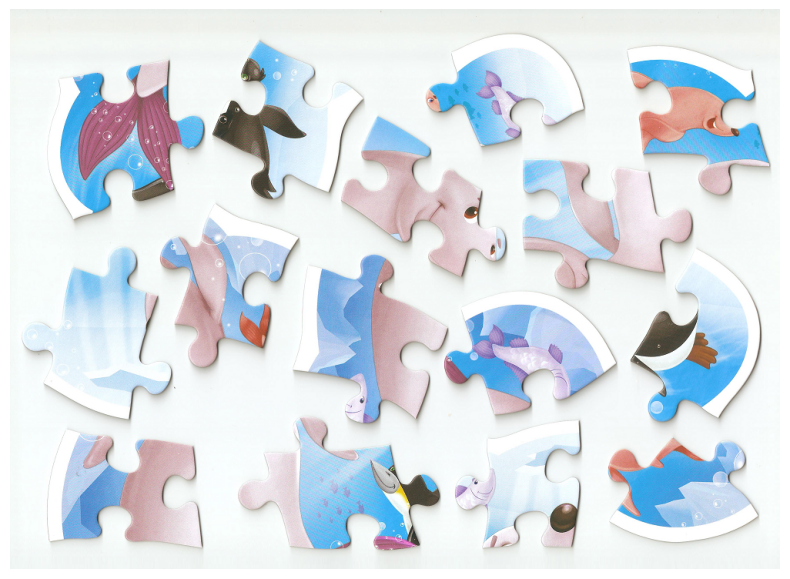

In [18]:
# Load scanned tiles
puzzle = np.array(Image.open('puzzle.png').convert('RGBA'))
print(puzzle.shape)
showpic(puzzle)

Now that we can detect the colors in the image, we need to separate the image into its individual puzzle pieces. To do this, we need to find and remove the background of the image. This can be done with Adaptive Thresholding. Adaptive Thresholding works by comparing the pixel values of the image to a threshold value. If the pixel value is greater than the threshold value, the pixel is set to a maximum value. If the pixel value is less than the threshold value, the pixel is set to a minimum value. This creates a binary image where the foreground is white and the background is black.

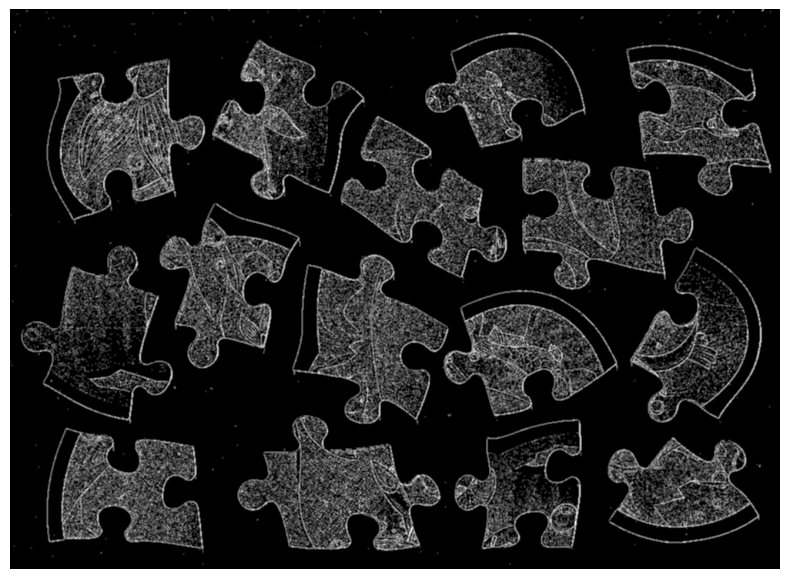

In [19]:
# Adaptive thresholding
thresh = cv2.cvtColor(puzzle, cv2.COLOR_RGBA2GRAY)
thresh = cv2.adaptiveThreshold(thresh, 255, 0, 1, 3, 3)
thresh = cv2.GaussianBlur(thresh, (3,3), 1)
showpic(thresh)

This is good but we need it to be even clearer so we can easily detect the edges of the puzzle pieces. To do this, we'll user OpenCV contour detection and fill technique. This will allow us to detect the edges of the puzzle pieces (contours) and fill them in with white color.

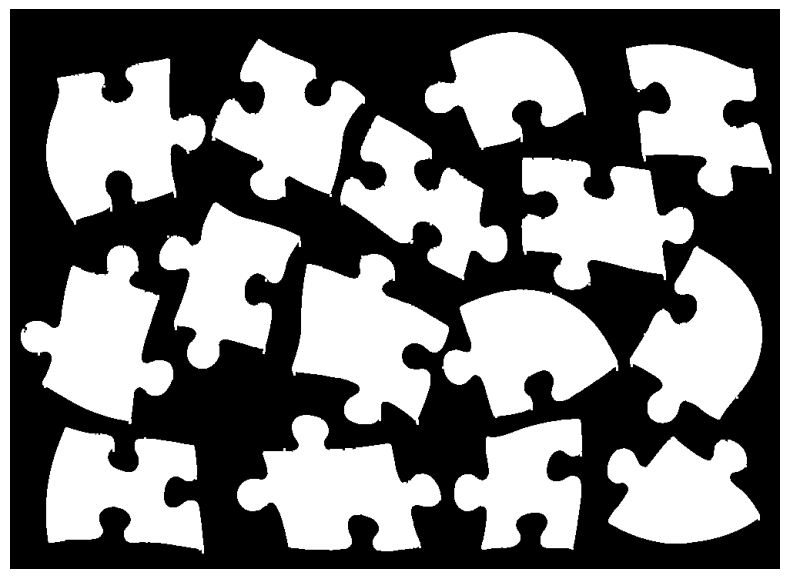

In [20]:
# Find and fill contours (puzzle pieces)
contours, _ = cv2.findContours(thresh, 0, 1)
sorting = sorted([[cnt.shape[0], i] for i, cnt in enumerate(contours)], reverse=True)[:15]
biggest = [contours[s[1]] for s in sorting] 
fill = cv2.drawContours(np.zeros(puzzle.shape[:2]), biggest, -1, 255, thickness=cv2.FILLED)
showpic(fill)

We're getting there, but we need to make the puzzle pieces even clearer! The tiles still have ragged edges and we need to make them smoother.

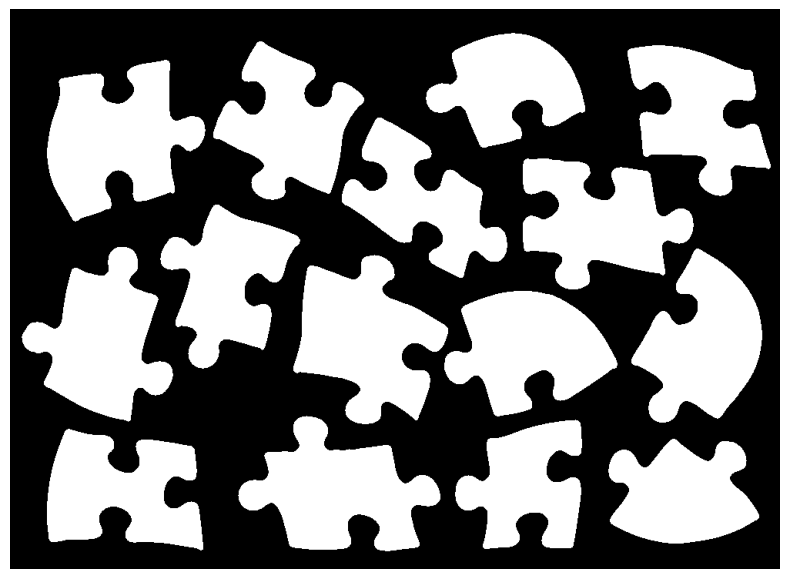

In [21]:
# Smooth contours (puzzle pieces) and trim shadows
smooth = median_filter(fill.astype('uint8'), size=10)
trim_contours, _ = cv2.findContours(smooth, 0, 1)
cv2.drawContours(smooth, trim_contours, -1, color=0, thickness=1)
showpic(smooth)

Now we're talking! Now the image is binary: the puzzle pieces are white and the background is black. We can now *superimpose* this image on the original image to get the colored puzzle pieces one by one(superimpose just means to overlay one image on top of another). 

We'll use the `boundingRect()` function to help us cut each tile out of the image to store them seperately. This function returns the coordinates of the puzzle pieces (contours). We can use these coordinates to save the locations of the puzzle pieces.

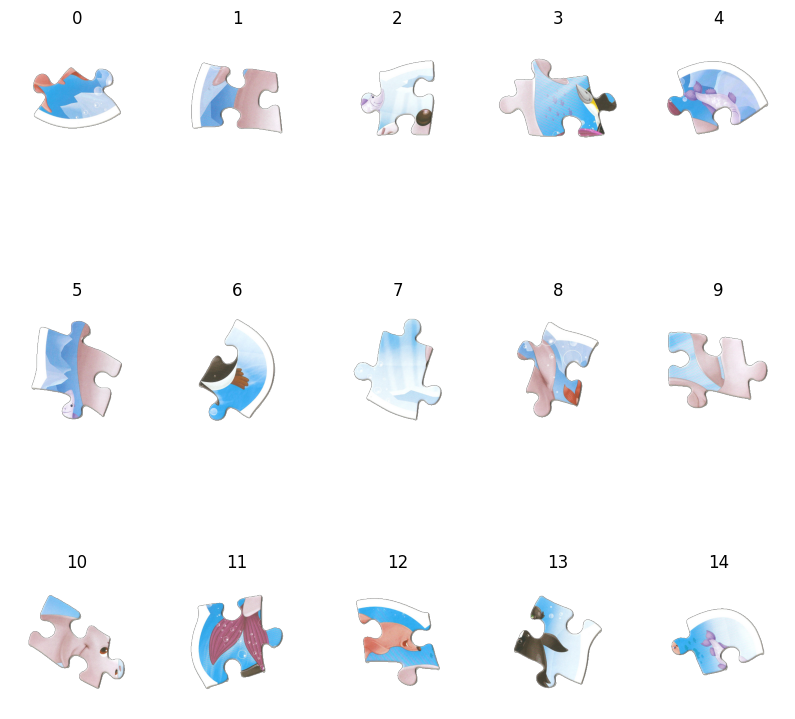

In [22]:
# Split into tiles
contours, _ = cv2.findContours(smooth, 0, 1)
tiles, tile_centers = [], []
for i in range(len(contours)):
  x, y, w, h = cv2.boundingRect(contours[i])
  shape, tile = np.zeros(puzzle.shape[:2]), np.zeros((300,300,4), 'uint8')
  cv2.drawContours(shape, [contours[i]], -1, color=1, thickness=-1)
  shape = (puzzle * shape[:,:,None])[y:y+h,x:x+w,:]
  tile[(300-h)//2:(300-h)//2+h,(300-w)//2:(300-w)//2+w] = shape
  tiles.append(tile)
  tile_centers.append((h//2+y, w//2+x))

showlist(tiles)

# Matching

Matching is the process of comparing multiple puzzle pieces to find the best match. In our case, we will take a pair of puzzle pieces and look for similar parts in their contours. We will then compare colors along those parts and try to lock the parts together without losing any pixels.

We'll start off just by rescaling the tiles just to place them on a larger canvas. This will make it easier to compare the tiles.

In [23]:
# Rescale tiles to assembly format
canvas_tiles = []
for i in range(len(tiles)):
  canvas_tile = np.zeros((1400,1400,4), 'uint8')
  canvas_tile[550:850, 550:850] = tiles[i].copy()
  canvas_tiles.append(canvas_tile)

Now we're going to define a bunch of functions to be used in the matching algorithm:

1. `getColours()` - This function will return a list of the color pixels along the contour (edges) of the puzzle piece.
2. `putOnAnvil()` - This function is pretty technical. It will basically just properly place the puzzle piece on the canvas.
3. `rotatePoint()` - This function will help track the tile position and rotation of the tile when we are assempling them together.
4. `reScale()` - This function is again pretty technical but it will help us rescale the puzzle pieces from the (300, 300) canvas to our new (1400, 1400) canvas.

In [24]:
# @title Functions

def getColors(image, subcontour):
  subcontour = np.flip(subcontour)

  colors = []
  for n in range(len(subcontour)-3):
    (y,x) = subcontour[n]
    (y1,x1) = subcontour[n+3]
    h, w = y1 - y, x1 - x
    colors.append(image[y-w, x+h, :3] + image[y+w, x-h, :3])

  colors = np.array(colors, 'uint8').reshape(-1,1,3)
  colors = cv2.cvtColor(colors, cv2.COLOR_RGB2HSV)
  
  return colors.reshape(-1,3)

def putOnAnvil(arr_img, point, angle, center=(700,700)):
  img = Image.fromarray(arr_img)
  img = ImageChops.offset(img, center[1] - point[1], center[0] - point[0])
  img = img.rotate(angle)

  return np.array(img)

def rotatePoint(point, angle, center=(700,700)):
  dy, dx = center[0]-point[0], point[1]-center[1]
  distance = np.sqrt(np.square(point[0]-center[0]) + np.square(point[1]-center[1]))
  if dx==0: dx = 1
  base = 90*(1-np.sign(dx)) + np.degrees(np.arctan(dy/dx))
  
  y = round(center[0] - distance * np.sin(np.pi * (base + angle)/180))
  x = round(center[1] + distance * np.cos(np.pi * (base + angle)/180))

  return (y,x)

def reScale(point, position, center=(150,150)):
  cy, cx, angle = position
  if angle!=0: (y, x) = rotatePoint(point, angle, center)
  else: (y, x) = point

  return (y + cy - center[0], x + cx - center[1])

Now comes the main function for matching the puzzle pieces. It looks scary, but it's not that bad and can be broken down into smaller parts. 

The function will go through 3 matching loops: contour (puzzle piece) matching, color matching, and puzzle piece fitting. The idea is to continuously reduce the number of matches, filtering bad ones out by certain criteria. More info on each loop section is found in matching section of the article.

In [25]:
# @title Matching algorithm
def matchTiles(A, B):

  LENGTH = 160
  PRECISION = 8
  STEP_A = 20
  STEP_B = 7
  MAX_FORM = 0.015
  MAX_COLOR = 8000
  MAX_PIXEL = 0.03
  MAX_FIT = 0.77

  CENTER = round(LENGTH/2)

  tileA, tileB = tiles[A], tiles[B]
  cntA, _ = cv2.findContours(tileA[:,:,3], 0, 1)
  cntB, _ = cv2.findContours(tileB[:,:,3], 0, 1)
  cntA, cntB = cntA[0].reshape(-1,2), cntB[0].reshape(-1,2)
  sumLen = cntA.shape[0] + cntB.shape[0]

  # Contour matching
  form_matches = []
  for i in range(0, cntA.shape[0], STEP_A):

    # subcontour A and its type
    subcA = np.roll(cntA, -i, 0)[:LENGTH]
    pointA = tuple(np.flip(subcA[CENTER]))
    cA, (hA,wA), aA = cv2.minAreaRect(subcA)
    typepointA = np.intp(np.flip(subcA[0] + subcA[-1] - cA))
    typeA = tileA[:,:,3][tuple(typepointA)]
    a = cv2.drawContours(np.zeros((300,300),'uint8'), subcA.reshape(-1,1,2), -1, 255, 1)

    # loop through match subcontours
    for j in range(0, cntB.shape[0], STEP_B):
      
      # subcontour B and its type
      subcB = np.roll(cntB, -j, 0)[:LENGTH]
      pointB = tuple(np.flip(subcB[CENTER]))
      cB, (hB,wB), aB = cv2.minAreaRect(subcB)
      typepointB = np.intp(np.flip(subcB[0] + subcB[-1] - cB))
      typeB = tileB[:,:,3][tuple(typepointB)]

      # record good form matches
      if typeB != typeA:
        if ((abs(hA-hB) < PRECISION) & (abs(wA-wB) < PRECISION)) or ((abs(hA-wB) < PRECISION) & (abs(wA-hB) < PRECISION)):
          b = cv2.drawContours(np.zeros((300,300),'uint8'), subcB.reshape(-1,1,2), -1, 255, 1)
          fmatch = cv2.matchShapes(a,b,1,0)
          if fmatch < MAX_FORM: 
            colinear = True if np.sign(hA-wA) == np.sign(hB-wB) else False
            if colinear:
              codirect = True if (np.sign(typepointA - np.flip(cA)) ==  np.sign(typepointB - np.flip(cB))).all() else False
            else:
              c = np.concatenate([np.sign(typepointA - np.flip(cA)), np.sign(typepointB - np.flip(cB))])
              codirect = True if (abs(np.sum(c[:3])) + abs(np.sum(c[-3:]))) == 4 else False
            if not colinear: aB = aB + 90
            if not codirect: aB = aB + 180  
            form_matches.append([(i, j), pointA, pointB, round(aB-aA,4), round(fmatch,4)])
 
  # Color matching
  color_matches = []
  for n in range(len(form_matches)):
    (i, j), pointA, pointB, angle, fmatch = form_matches[n]
    subcA = np.roll(cntA, -i, 0)[:LENGTH] 
    subcB = np.roll(cntB, -j, 0)[:LENGTH]
    colorsA = getColors(tileA, subcA)
    colorsB = getColors(tileB, subcB)
    cmatch = fastdtw(colorsA, np.flip(colorsB, axis=0))[0]
    if cmatch < MAX_COLOR: 
      color_matches.append([(i, j), pointA, pointB, angle, fmatch, round(cmatch)])

  # Pre-fitting
  fit_matches = []
  for n in range(len(color_matches)):
    (i, j), pointA, pointB, angle, fmatch, cmatch = color_matches[n]
    a = putOnAnvil(canvas_tiles[A][:,:,3], reScale(pointA, [700,700,0]), 0)
    b = putOnAnvil(canvas_tiles[B][:,:,3], reScale(pointB, [700,700,0]), angle)
    loss = 1 - (np.sum((a+b)>0) / (np.sum(a>0) + np.sum(b>0)))
    contours, _ = cv2.findContours((a+b), 0, 1)
    fit = contours[0].shape[0] / sumLen
    if (loss < MAX_PIXEL) & (fit < MAX_FIT): 
      fit_matches.append([(A, B), (i, j), pointA, pointB, angle, fmatch, cmatch, round(loss+fit,4), 0])

  fit_matches.sort(key=lambda n: n[-1])

  return fit_matches

Here is where we will run the matching algorithm, calculating the best matches for each puzzle piece. This will take a while to run, so be patient!

In [26]:
# Calculate all possible matches
matches = []
for a in range(len(tiles)-1):
  for b in range(a+1,len(tiles)):
    matches.extend(matchTiles(a,b))

#artificially add missing match ERROR
matches.append([(4, 11), (100, 14), (177, 40), (101, 142), 276.7329, 0.0041, 7969, 0.7417, 0])
matches.append([(11, 4), (100, 14), (101, 142), (177, 40), -276.7329, 0.0041, 7969, 0.7417, 0])

# Flip and sort
for n in range(len(matches)):
  pair, ij, pointa, pointb, angle, fmatch, cmatch, fit, lock = matches[n]
  matches.extend([[(pair[1],pair[0]), ij, pointb, pointa, -angle, fmatch, cmatch, fit, lock]])
matches.sort(key=lambda m: (m[0], m[-2]))



# Print all matches
for m in matches:
    print(m,"\n")


[(0, 8), (400, 441), (94, 225), (141, 172), 246.8937, 0.0067, 6518, 0.7093, 0] 

[(0, 8), (420, 413), (85, 205), (169, 171), 245.9947, 0.0092, 6423, 0.7186, 0] 

[(0, 8), (400, 427), (94, 225), (155, 168), 244.559, 0.0142, 7056, 0.7384, 0] 

[(1, 5), (160, 735), (180, 117), (42, 144), 22.6352, 0.0038, 7153, 0.7148, 0] 

[(1, 8), (660, 28), (127, 147), (106, 60), 100.7665, 0.0083, 7031, 0.7389, 0] 

[(2, 7), (500, 483), (155, 230), (174, 206), 186.3368, 0.0116, 4744, 0.7574, 0] 

[(2, 7), (500, 476), (155, 230), (181, 206), 186.3368, 0.0141, 5255, 0.7804, 0] 

[(2, 14), (140, 287), (164, 67), (163, 170), 66.5094, 0.0054, 7399, 0.7326, 0] 

[(2, 14), (140, 294), (164, 67), (161, 177), 66.5094, 0.0051, 7469, 0.743, 0] 

[(2, 14), (140, 301), (164, 67), (161, 184), 66.5094, 0.0098, 7829, 0.7594, 0] 

[(3, 9), (720, 700), (101, 130), (78, 125), 189.6861, 0.0049, 6613, 0.7515, 0] 

[(3, 9), (700, 707), (106, 149), (72, 120), 187.9308, 0.0065, 7538, 0.7807, 0] 

[(3, 11), (340, 602), (194, 19

# Assembly

The main idea in assembly is to go through the matches and try to lock the pieces together. We do this by superimposing the pieces on top of each other and rotating them to find the best fit. We then lock the pieces together by merging them.

We will use a helpful function (`updateCanvas()`) to simplify the algorithm. This function keeps records of tiles positions and angles on the canvas when the puzzle pieces are assembled.

In [27]:
# @title Functions

def updateCanvas(canvas, positions, pointA, pointB, angleA, angleB):
  # update records for tiles on canvas
  for N, pos in enumerate(positions):
    if N in canvas:
      new_center = (pos[0] + 700 - pointA[0], pos[1] + 700 - pointA[1])
      new_center = rotatePoint(new_center, angleA)
      new_angle = pos[2] + angleA
      positions[N] = [*new_center, new_angle]

  # append record for the added tile
  canvas.append(B)
  center = rotatePoint((700 + 700 - pointB[0], 700 + 700 - pointB[1]), angleB)
  positions[B] = [*center, angleB]

  return canvas, positions

Our puzzle has 22 joints, but the matching algortihm has returned 37 matches. This technically means we need to do more filtering, but for simplicity we will drop the replacement of tiles and just have a max of 10 attempts to assemble the puzzle.

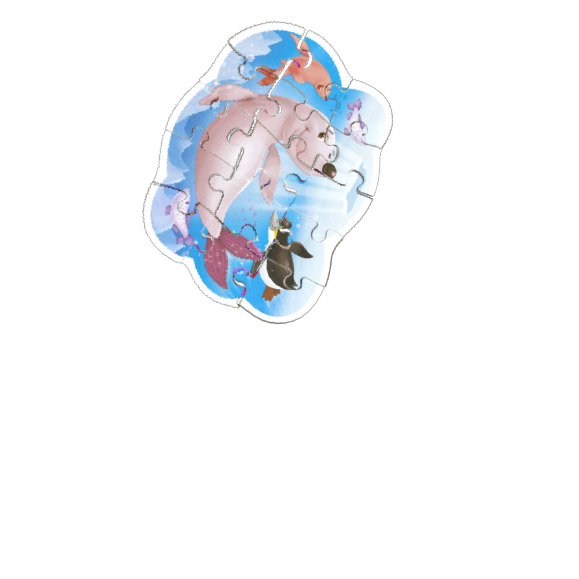

In [28]:
# Assembly
assembly = canvas_tiles[0].copy()
positions = [[0,0,0]]*len(tiles)
positions[0] = [700,700,0]
canvas = [0]
attempts = 0

while (len(canvas) < 15) & (attempts < 10):
  for n in range(len(matches)):
    # take next matching pair
    (A, B), ij, pointA, pointB, angleB, _, _, _, lock = matches[n]
    pointA = reScale(pointA, positions[A])
    pointB = reScale(pointB, (700,700,0))

    if A in canvas:
      angleA = - positions[A][2]
      pre_assembly = putOnAnvil(assembly.copy(), pointA, angleA)
      
      if B not in canvas:
        newtile = putOnAnvil(canvas_tiles[B], pointB, angleB)

        # fix or pass depending on loss of pixels
        loss = (np.sum(pre_assembly[:,:,3]>0) + np.sum(newtile[:,:,3]>0) - 
                np.sum((pre_assembly+newtile)[:,:,3]>0)
                ) / np.sum(newtile[:,:,3]>0)
        if loss < 0.1: 
          matches[n][-1] = 1
          assembly = pre_assembly.copy() + newtile.copy()
          canvas, positions = updateCanvas(canvas, positions, 
                                           pointA, pointB, angleA, angleB)
  
  attempts += 1

showpic(assembly)

The image looking a bit worn out is just due to the distortion of information when the puzzle pieces are merged. Other than that, this works fine! We have successfully assembled the puzzle!

To conclude, we will mark the orignal tiles with the matches found. This will help us visualize the matches and see how to put the puzzle together from scratch. For each pair, we draw circles of a specific color in the lock positions and put a match number inside of both.

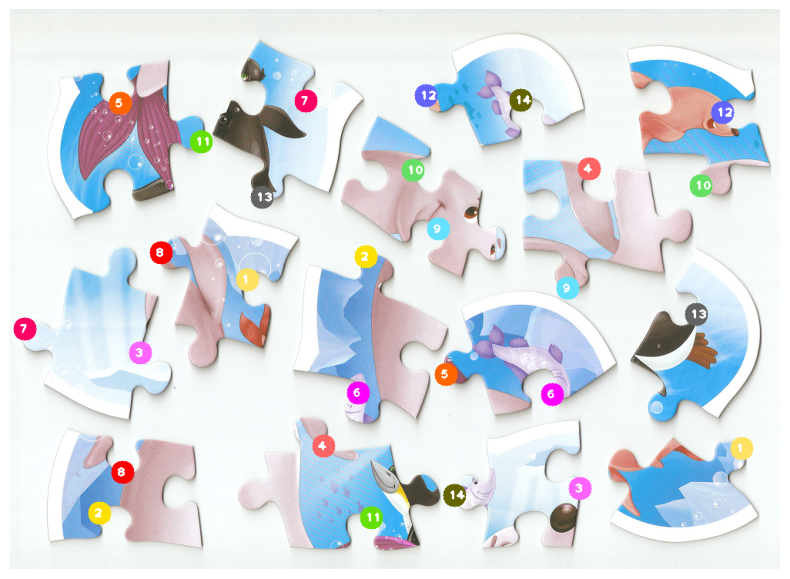

In [32]:
# Mark matches in original image
count = 0
markup = puzzle.copy()
colors = [[r,g,b,255] for r in [255,100,0] for g in [225,100,0] for b in [255,100,0]]
for n in range(len(matches)):
  (A, B), _, pointA, pointB, _, _, _, _, lock = matches[n]
  if lock == 1:
    count += 1
    centerA = (tile_centers[A][1]-(150-pointA[1]), tile_centers[A][0]-(150-pointA[0]))
    centerB = (tile_centers[B][1]-(150-pointB[1]), tile_centers[B][0]-(150-pointB[0]))
    cv2.circle(markup, centerA, 15, colors[count], -1)
    cv2.circle(markup, centerB, 15, colors[count], -1)
    cv2.putText(markup, str(count), (centerA[0]-7,centerA[1]+5), 1, 1, [255,255,255,255], 2)
    cv2.putText(markup, str(count), (centerB[0]-7,centerB[1]+5), 1, 1, [255,255,255,255], 2)

showpic(markup)